In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import pathlib
import pickle
import random
import time

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.functional import interpolate
from torch.utils.data import DataLoader
from torchvision.transforms.functional import adjust_brightness

from super_resolution.src.sen2venus_dataset import (
    create_train_test_split,
    create_train_validation_test_split,
    default_patch_transform,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, TruncatedVGG19, Discriminator

In [3]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

## Prepare Data

In [4]:
sites = {
    "SO2",
    # "ES-LTERA",
    # "FR-LAM",
    "FR-BIL",
    "NARYN",
}
train_patches, test_patches = create_train_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(
    f"Num train {len(train_patches)}\n"
    # f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 8159
Num test 3498


In [8]:
def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = torch.clamp(x, 0, 1)
    y = torch.clamp(y, 0, 1)

    return x, y

In [9]:
train_patches.set_transform(image_transform)
test_patches.set_transform(image_transform)

In [10]:
train_loader = DataLoader(train_patches, batch_size=100)

In [11]:
(low_res, high_res) = next(train_loader.__iter__())

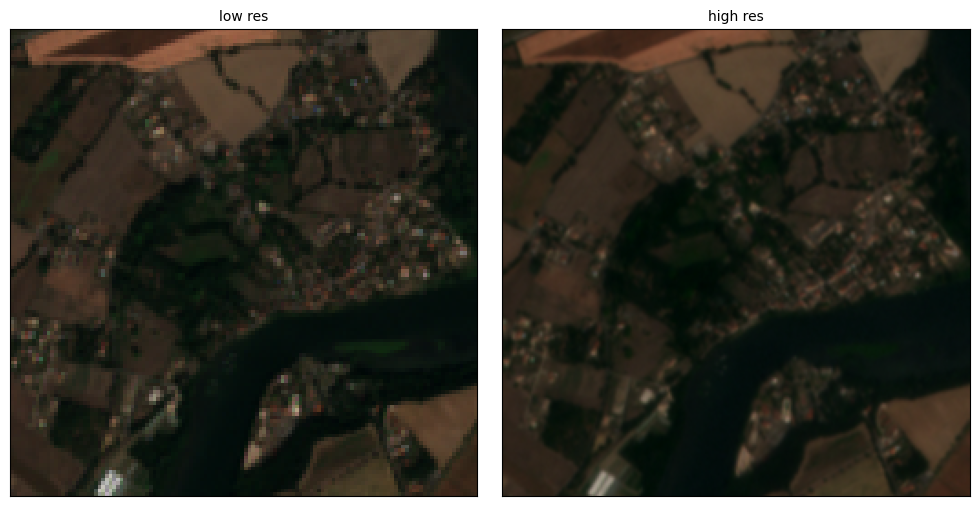

In [12]:
index = random.randint(0, len(low_res) - 1)
low_res_example = low_res[index]


high_res_example = high_res[index]


plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

## Training

In [311]:
# For clearing GPU memory
1 / 0

ZeroDivisionError: division by zero

In [ ]:
# For clearing GPU memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,  # Always set to true for training
    batch_size=16,  # Always try to set as powers of 2
    drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
    pin_memory=should_pin_memory[device.type],  # Faster push to GPU
    num_workers=0,  # Load data in parallel but costs more memory
)

In [14]:
device

device(type='cuda')

In [18]:
generator = SRResNet(scaling_factor=2, n_blocks=8)

In [19]:
discriminator = Discriminator(n_blocks=2, fc_size=128)

In [149]:
generator = generator.to(device)
generator = generator.train()

In [21]:
discriminator = discriminator.to(device)
discriminator = discriminator.train()

In [22]:
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0001)
discrim_optimizer = optim.Adam(discriminator.parameters(), lr=0.000001)

In [ ]:
# save_file = RESULTS_DIR / "decentishsrgan_beforebatchnorm.pkl"
# loaded_experiment = torch.load(save_file, map_location=device)
# # generator = SRResNet(scaling_factor=2, n_blocks=4).to(device)
# generator.load_state_dict(loaded_experiment["gen_state"])
# discriminator.load_state_dict(loaded_experiment["discrim_state"])
# gen_optimizer.load_state_dict(loaded_experiment["gen_optimizer_state"])
# discrim_optimizer.load_state_dict(loaded_experiment["discrim_optimizer_state"])
# gen_losses = loaded_experiment["gen_epoch_losses"]
# discrim_losses = loaded_experiment["discrim_losses"]

In [23]:
pixel_criterion = nn.MSELoss()
discrim_criterion = nn.BCEWithLogitsLoss()

In [24]:
# vgg = TruncatedVGG19().to(device)
# vgg = vgg.eval()
# vgg = vgg.requires_grad_(False)

In [25]:
NUM_EPOCHS = 2000

In [26]:
train_time = 0.0
gen_losses = []
discrim_losses = []

In [150]:
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    gen_epoch_loss = 0.0
    discrim_epoch_loss = 0.0
    num_batches = 0
    for low_res_batch, high_res_batch in progress_bar:
        num_batches += 1
        start_time = time.time()

        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        # Update generator
        ############################################################################################
        super_resolved = generator(low_res_batch).clamp(0, 1)
        natural_probs = discriminator(super_resolved)

        pixel_loss = pixel_criterion(super_resolved, high_res_batch)
        discrim_loss = discrim_criterion(natural_probs, torch.ones_like(natural_probs))
        gen_loss = pixel_loss + 1e-3 * discrim_loss

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # Update discriminator
        ############################################################################################
        true_natural_probs = discriminator(high_res_batch)

        # Detach to skip generator computations
        fake_natural_probs = discriminator(super_resolved.detach())

        true_natural_loss = discrim_criterion(
            true_natural_probs, torch.ones_like(true_natural_probs)
        )
        fake_natural_loss = discrim_criterion(
            fake_natural_probs, torch.ones_like(fake_natural_probs)
        )
        adversarial_loss = true_natural_loss + fake_natural_loss

        # Do not let discrim get too much advantage
        if adversarial_loss.item() > 1e-03:
            discrim_optimizer.zero_grad()
            adversarial_loss.backward()
            discrim_optimizer.step()

        # Collect data
        gen_epoch_loss += gen_loss.item()
        discrim_epoch_loss += discrim_loss.item()
        progress_bar.set_postfix(
            epoch=epoch,
            gen_loss=f"{gen_epoch_loss/num_batches:.8f}",
            discrim_loss=f"{discrim_epoch_loss/num_batches:.8f}",
        )

        end_time = time.time()
        train_time += end_time - start_time

    gen_epoch_loss /= len(train_loader)
    discrim_epoch_loss /= len(train_loader)
    gen_losses.append(gen_epoch_loss)
    discrim_losses.append(discrim_epoch_loss)
    print(
        f"Epoch: {epoch} / gen_loss: {gen_epoch_loss:.8f} / discrim_loss: {discrim_epoch_loss:.8f}"
    )

 48%|██▊   | 242/509 [04:46<05:01,  1.13s/it, discrim_loss=0.00276172, epoch=0, gen_loss=0.00003680]

In [88]:
train_time / 60

47.041495112578076

In [89]:
len(gen_losses)

13

In [90]:
gen_losses[-5:]

[4.805232400956522e-05,
 4.507321059222499e-05,
 4.231287071488552e-05,
 3.962213642900825e-05,
 3.896477854191298e-05]

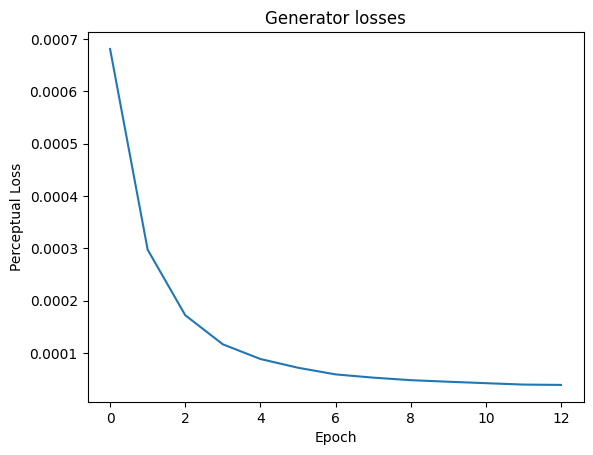

In [91]:
plt.plot(gen_losses)
plt.title("Generator losses")
plt.xlabel("Epoch")
plt.ylabel("Perceptual Loss")
plt.show()

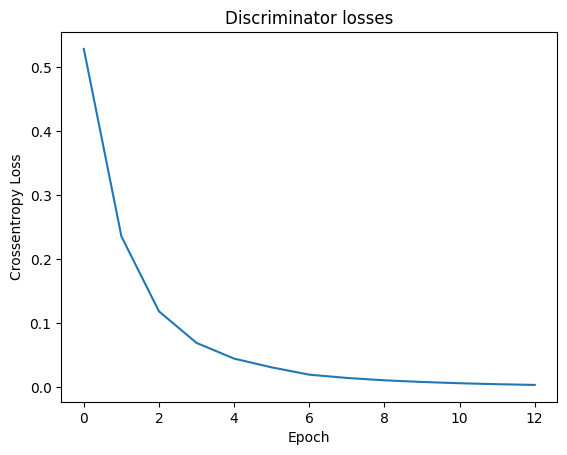

In [92]:
plt.plot(discrim_losses)
plt.title("Discriminator losses")
plt.xlabel("Epoch")
plt.ylabel("Crossentropy Loss")
plt.show()

## Saving

In [145]:
experiment = {
    "gen_losses": gen_losses,
    "discrim_losses": discrim_losses,
    "gen_state": generator.state_dict(),
    "discrim_state": discriminator.state_dict(),
    "gen_optimizer_state": gen_optimizer.state_dict(),
    "discrim_optimizer_state": discrim_optimizer.state_dict(),
}

In [146]:
save_file = RESULTS_DIR / "greatsrgan_withoutbatchnorm_firstbeatbicubic.pkl"

In [147]:
if not save_file.exists():
    torch.save(experiment, save_file)

## Generated Examples

In [93]:
generator = generator.to("cpu")

In [94]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(loader.__iter__())

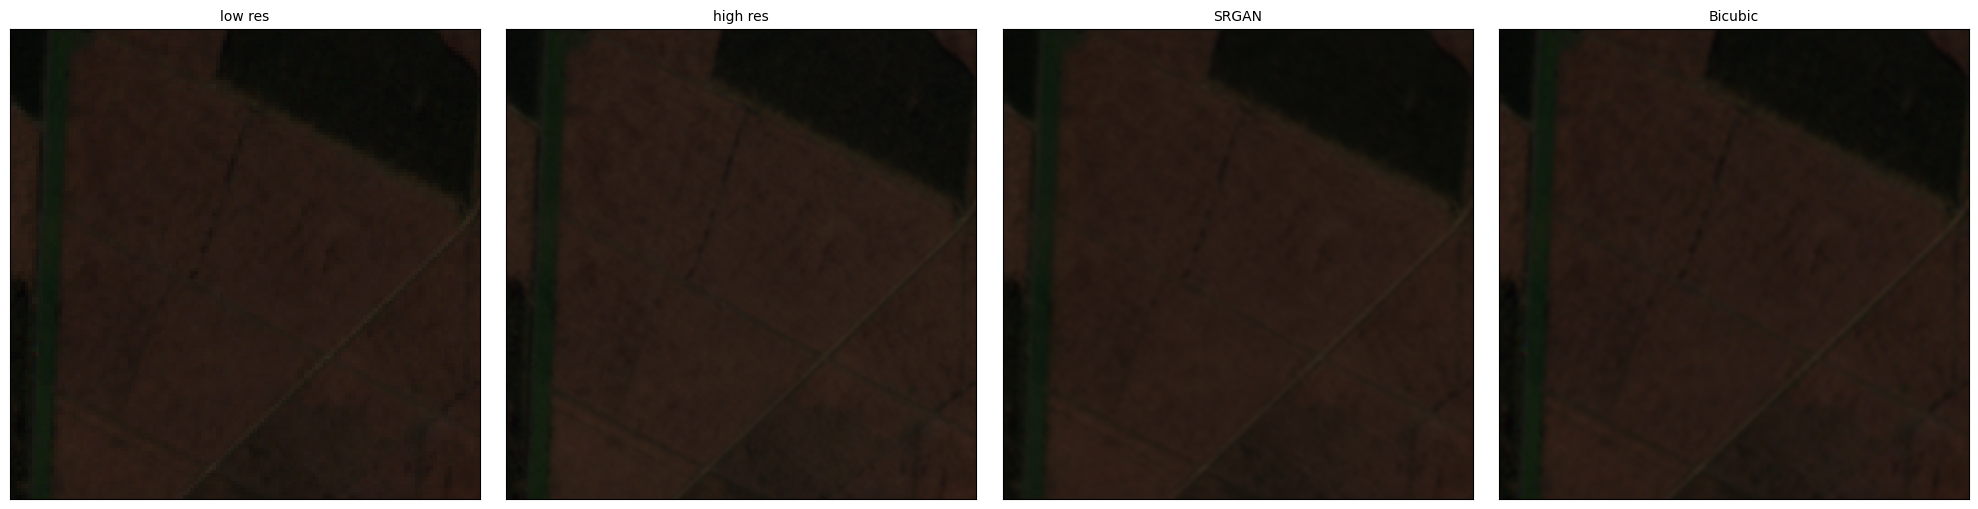

In [111]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = interpolate(
    low_res_example.unsqueeze(0),
    size=(256, 256),
    mode="bicubic",
).float()
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [112]:
loader = DataLoader(test_patches, batch_size=100)
(low_res, high_res) = next(loader.__iter__())

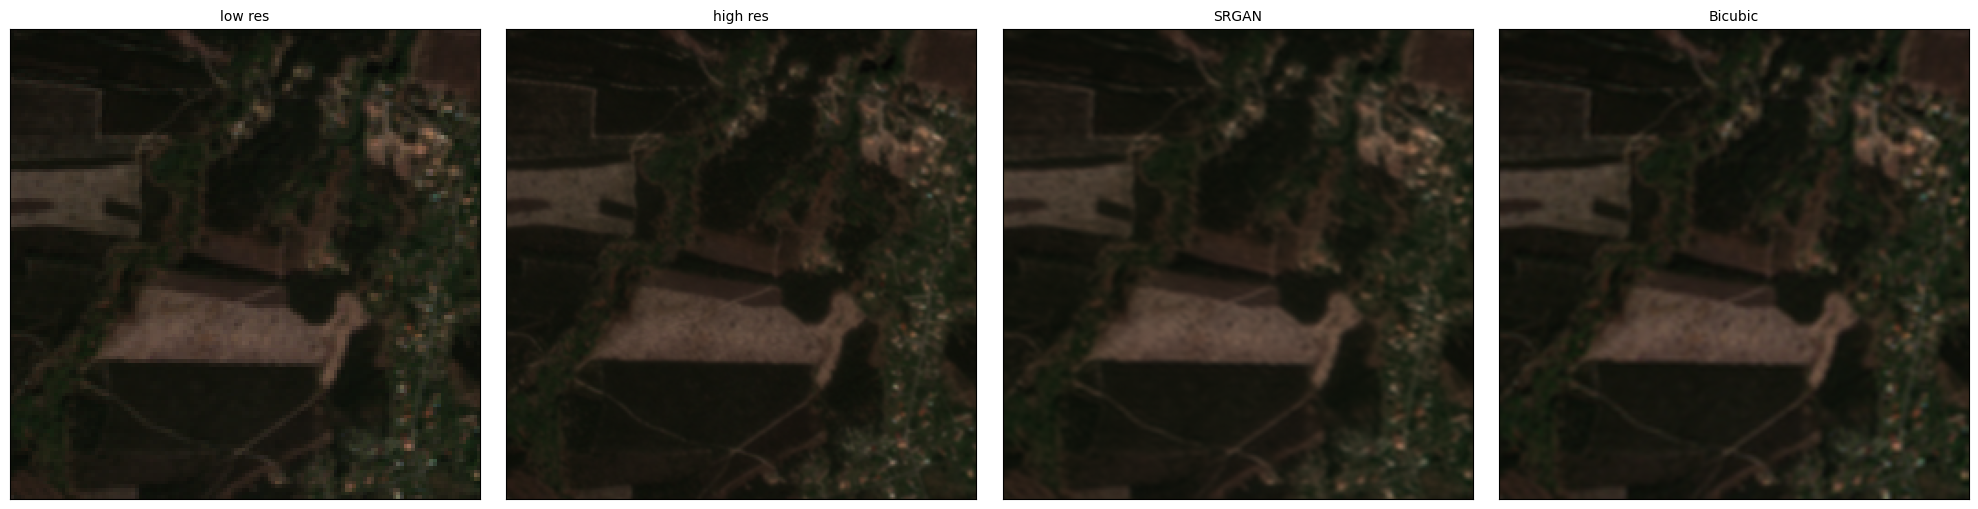

In [144]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = (
    interpolate(low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic")
    .float()
    .clamp(0, 1)
)
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

## Metrics

In [127]:
from super_resolution.src.testing import compute_metrics

In [128]:
# 256 is largest I can handle on cpu
metric_loader = DataLoader(test_patches, batch_size=min(len(test_patches), 256))

In [129]:
metrics = compute_metrics(lambda x: generator(x).clamp(0, 1), metric_loader)

100%|███████████████████████████████████████████████████████████████| 14/14 [15:39<00:00, 67.09s/it]


In [131]:
metrics

Metrics(mse=3.8191878307510964e-05, psnr=44.18847928728376, ssim=0.9862063229084015, fid=1.169891357421875)

In [ ]:
bicubic_metrics = compute_metrics(
    lambda x: interpolate(x, size=(256, 256), mode="bicubic"), metric_loader
)

In [ ]:
bicubic_metrics

Metrics(mse=4.024813668885534e-05, psnr=43.96280016217913, ssim=0.9836511441639492, fid=tensor(1.3964))